In [1]:
import numpy as np
import scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import common_modeling_lib 
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

import os

np.random.seed(453453)


import json
import json_tricks
import checkpoints
from checkpoints import np_string

from stability_utils import get_expected_mutual_info, get_fowlkes_mallows_score


def comparison_plot(x, y): 
    plt.plot(x, y, 'r+')
    plt.plot(x, x)

# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

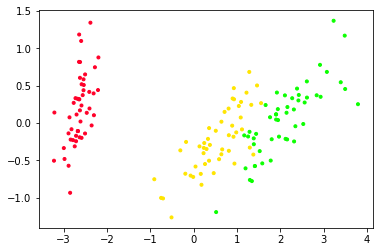

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

In [8]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Load full model

In [9]:
full_data_fit_file = './iris_fits/full_data_fits/iris_bnp_full_data_fit.json'

In [10]:
with open(full_data_fit_file, 'r') as fp:
    fit_dict = json.load(fp)

full_model = gmm_utils.get_model_from_checkpoint(fit_dict)

assert full_model.use_weights == False

full_global_free_param = full_model.global_vb_params.get_free()
prior_free_param = full_model.prior_params.get_free()
full_model.set_optimal_z()

In [11]:
model = deepcopy(full_model) # this is the one we will pass around
# full data models will stay the same

# look at full model fit

In [12]:
bnp_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [13]:
bnp_centroids_pc, bnp_cluster_covs_pc = transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

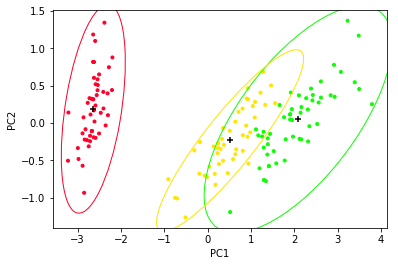

In [14]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

# Load bootstrap results

In [15]:
linf_diff = lambda x, y : np.max(np.abs(x - y))

In [16]:
def get_global_free_params_and_weights_from_fit_dict(fit_dict):
    np_string = checkpoints.np_string
    vb_global_free_par = json_tricks.loads(
            fit_dict['vb_global_free_par' + np_string])

    sample_weights = json_tricks.loads(
        fit_dict['sample_weights' + np_string])

    return {'vb_global_free_par': vb_global_free_par, \
            'sample_weights': sample_weights}


In [17]:
def load_bootstrap_results(gmm_full, result_files, print_every_n=10):

    results = []
    i = 0
    if len(result_files) == 0:
        raise ValueError('No result files were specfied.')
    for f in result_files:
        i += 1
        if (i % print_every_n) == 0:
            print('files opened: ', i)

        with open(f, 'r') as fp:
            fit_dict = json.load(fp)


            assert linf_diff(json_tricks.loads(fit_dict['prior_params_vec' + np_string]), \
                                 gmm_full.prior_params.get_vector()) < 1e-12

            # check that the length of the free params are the same ..
            assert len(json_tricks.loads(fit_dict['vb_global_free_par' + np_string])) == \
                        len(gmm_full.global_vb_params.get_free())

            # check y
            assert linf_diff(json_tricks.loads(fit_dict['y' + np_string]), gmm_full.y) < 1e-12

        results.append(get_global_free_params_and_weights_from_fit_dict(fit_dict))

    return results


In [18]:
boot_dir = './iris_fits/bootstrap_bnp_results/'

In [19]:
result_files = [os.path.join(boot_dir, f) for f in os.listdir(boot_dir) if \
                        os.path.isfile(os.path.join(boot_dir, f)) & \
                        f.endswith('.json')]


boot_results = load_bootstrap_results(model, result_files, print_every_n=50)


files opened:  50
files opened:  100
files opened:  150
files opened:  200


# Checkout stabilities

In [20]:
def get_ez_from_free_param(model, global_free_vb_params):
    model.global_vb_params.set_free(global_free_vb_params)
    model.set_optimal_z()
    
    return model.vb_params['e_z'].get()

In [21]:
def get_iqr(x): 
    return np.percentile(x, 75) - np.percentile(x, 25)

In [22]:
def get_stabilities_from_boot_results(model, full_vb_global_free_pars, \
                                      boot_vb_global_free_pars, return_full_array = False):
       
    fm_scores = np.zeros(len(boot_vb_global_free_pars))
    emi_scores = np.zeros(len(boot_vb_global_free_pars))

    for b in range(len(boot_vb_global_free_pars)): 
        e_z_full = get_ez_from_free_param(model, \
                               full_vb_global_free_pars)

        e_z_boot = get_ez_from_free_param(model, \
                               boot_vb_global_free_pars[b])

        fm_scores[b] = get_fowlkes_mallows_score(e_z_full, e_z_boot)
        emi_scores[b] = get_expected_mutual_info(e_z_full, e_z_boot)
        
    if return_full_array: 
        return fm_scores, emi_scores
    else: 
        return np.median(fm_scores), np.percentile(fm_scores, 75), np.percentile(fm_scores, 25),\
                np.median(emi_scores), np.percentile(emi_scores, 75), np.percentile(emi_scores, 25)
    

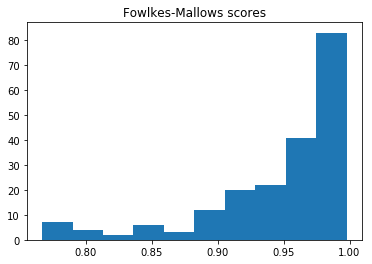

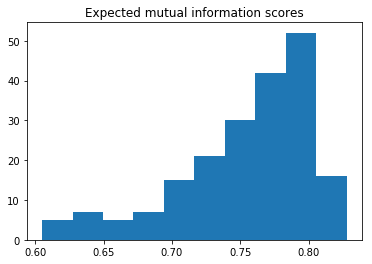

In [23]:
full_vb_global_free_pars = full_model.global_vb_params.get_free()
boot_vb_global_free_pars = np.array([x['vb_global_free_par'] for x in boot_results])

fm_scores, emi_scores = \
    get_stabilities_from_boot_results(model, full_vb_global_free_pars, \
                                      boot_vb_global_free_pars, return_full_array=True)

plt.hist(fm_scores)
plt.title('Fowlkes-Mallows scores')


plt.figure()
plt.hist(emi_scores)
plt.title('Expected mutual information scores')


# See how well LRVB matches these results

In [24]:
full_model.prior_params.set_free(prior_free_param)
full_model.global_vb_params.set_free(full_global_free_param)

In [25]:
moment_model = gmm_utils.InterestingMoments(full_model)
linear_sens = LinearSensitivity(full_model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [26]:
full_model.prior_params.set_free(prior_free_param)
full_model.global_vb_params.set_free(full_global_free_param)    

model.prior_params.set_free(prior_free_param)
model.global_vb_params.set_free(full_global_free_param)

### Check one bootstrap sample

In [27]:
def get_ij_estimate(linear_sens, sample_weights): 
    n_obs = np.shape(sample_weights)[0]
    return np.dot(linear_sens.data_sens_mat, \
                  sample_weights - np.ones((n_obs, 1))).flatten() + \
            linear_sens.optimal_global_free_params 

In [28]:
def run_lr_bootstrap(linear_sens, sample_weights_list): 
    n_boot = len(sample_weights_list)
    
    dim_free_pars = len(linear_sens.model.global_vb_params.get_free())
    
    lr_vb_global_free_pars = np.zeros((n_boot, dim_free_pars))
    for i in range(n_boot):
        lr_vb_global_free_pars[i, :] = get_ij_estimate(linear_sens, sample_weights_list[i])
    
    return lr_vb_global_free_pars

In [29]:
sample_weights_list = np.array([x['sample_weights'] for x in boot_results])

lr_vb_global_free_pars = run_lr_bootstrap(linear_sens, sample_weights_list) 

In [30]:
boot_vb_global_free_pars = np.array([x['vb_global_free_par'] for x in boot_results])

In [31]:
full_vb_global_free_pars = full_model.global_vb_params.get_free()

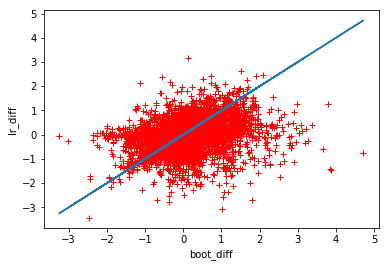

In [32]:
comparison_plot((boot_vb_global_free_pars - full_vb_global_free_pars).flatten(), 
               (lr_vb_global_free_pars - full_vb_global_free_pars).flatten())

plt.xlabel('boot_diff')
plt.ylabel('lr_diff')


### Lets get linear response estimates of the stability scores

In [37]:
k = 9
sample_weights_list = np.array([x['sample_weights'] \
                                for x in boot_results_dict['n_clusters{}'.format(k)]])

boot_vb_global_free_pars = np.array([x['vb_global_free_par'] \
                                for x in boot_results_dict['n_clusters{}'.format(k)]])

lr_vb_global_free_pars = run_lr_bootstrap(linear_sens_dict['n_clusters{}'.format(k)], sample_weights_list) 

In [35]:
lr_results = get_stabilities_from_boot_results(model, full_global_free_param, \
                                lr_vb_global_free_pars, return_full_array = True)

boot_results = get_stabilities_from_boot_results(model, full_global_free_param, \
                                boot_vb_global_free_pars, return_full_array = True)


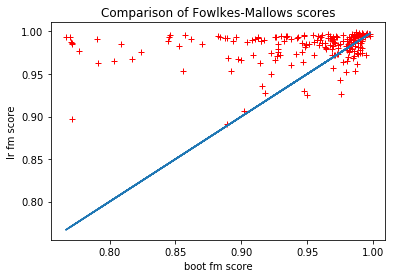

In [50]:
comparison_plot(boot_results[0], lr_results[0])
plt.xlabel('boot fm score')
plt.ylabel('lr fm score')
plt.title('Comparison of Fowlkes-Mallows scores')

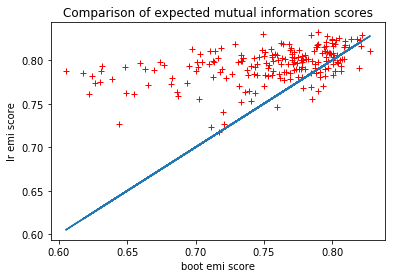

In [51]:
comparison_plot(boot_results[1], lr_results[1])
plt.xlabel('boot emi score')
plt.ylabel('lr emi score')
plt.title('Comparison of expected mutual information scores')

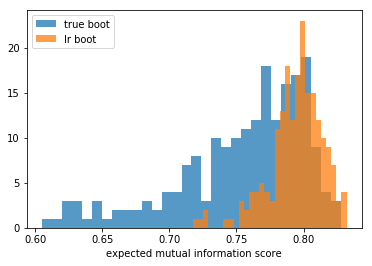

In [52]:
plt.hist(boot_results[1], bins = 30, alpha = 0.75); 
plt.hist(lr_results[1], bins = 30, alpha = 0.75); 
plt.legend(('true boot', 'lr boot')); 
plt.xlabel('expected mutual information score')

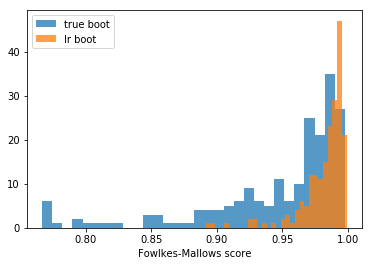

In [54]:
plt.hist(boot_results[0], bins = 30, alpha = 0.75); 
plt.hist(lr_results[0], bins = 30, alpha = 0.75); 
plt.legend(('true boot', 'lr boot')); 
plt.xlabel('Fowlkes-Mallows score')